In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import make_pipeline

from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
from sklearn.experimental import enable_hist_gradient_boosting  
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import fetch_california_housing

## MLLytics Packages

In [7]:
from MLLytics.interpretation import make_pdp, plot_pdp

## Some model

In [8]:
cal_housing = fetch_california_housing()
X = pd.DataFrame(cal_housing.data, columns=cal_housing.feature_names)
y = cal_housing.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,
                                                    random_state=0)

print("Training MLPRegressor...")
est = make_pipeline(QuantileTransformer(),
                    MLPRegressor(hidden_layer_sizes=(50, 50),
                                 learning_rate_init=0.01,
                                 early_stopping=True))
est.fit(X_train, y_train)
print("Test R2 score: {:.2f}".format(est.score(X_test, y_test)))

Training MLPRegressor...
Test R2 score: 0.81


In [9]:
#https://matplotlib.org/gallery/statistics/bxp.html
import matplotlib.cbook as cbook

# fake data
np.random.seed(19680801)
data = np.random.lognormal(size=(37, 4), mean=1.5, sigma=1.75)
labels = list('ABCD')

# compute the boxplot stats
stats = cbook.boxplot_stats(data, labels=labels, bootstrap=10000)

In [10]:
stats[0]

{'label': 'A',
 'mean': 13.608303993175577,
 'iqr': 16.62219300478486,
 'cilo': 1.411047419553718,
 'cihi': 14.255678889631325,
 'whishi': 30.32084269371291,
 'whislo': 0.019001878741670253,
 'fliers': array([44.43404261, 59.58829213, 77.10427139, 81.48295988]),
 'q1': 0.8281911963046644,
 'med': 3.650461454233603,
 'q3': 17.450384201089527}

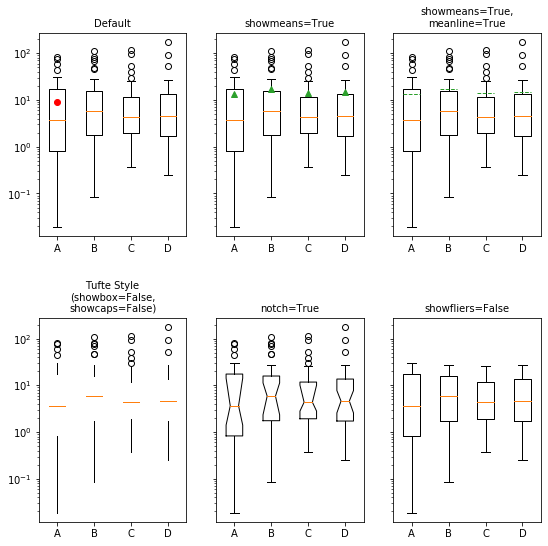

In [11]:
fs=10

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(9, 9), sharey=True)
axs[0, 0].bxp(stats)
axs[0, 0].set_title('Default', fontsize=fs)

axs[0, 1].bxp(stats, showmeans=True)
axs[0, 1].set_title('showmeans=True', fontsize=fs)

axs[0, 2].bxp(stats, showmeans=True, meanline=True)
axs[0, 2].set_title('showmeans=True,\nmeanline=True', fontsize=fs)

axs[1, 0].bxp(stats, showbox=False, showcaps=False)
tufte_title = 'Tufte Style\n(showbox=False,\nshowcaps=False)'
axs[1, 0].set_title(tufte_title, fontsize=fs)

axs[1, 1].bxp(stats, shownotches=True)
axs[1, 1].set_title('notch=True', fontsize=fs)

axs[1, 2].bxp(stats, showfliers=False)
axs[1, 2].set_title('showfliers=False', fontsize=fs)

for ax in axs.flat:
    ax.set_yscale('log')
    #ax.set_yticklabels([])

axs[0, 0].scatter(1, 9, color='red')    
    
fig.subplots_adjust(hspace=0.4)
plt.show()

[Text(0, 0, 'A'), Text(0, 0, 'B'), Text(0, 0, 'C'), Text(0, 0, 'Bla')]

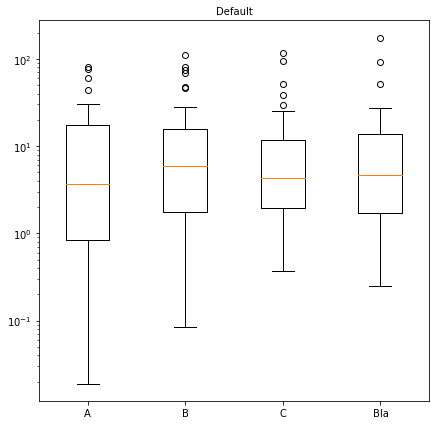

In [12]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7, 7), sharey=True)
axs.bxp(stats)
axs.set_title('Default', fontsize=fs)

axs.set_yscale('log')
axs.set_xticklabels(['A', 'B', 'C', 'Bla'])

Text(0.5, 1.0, 'Default')

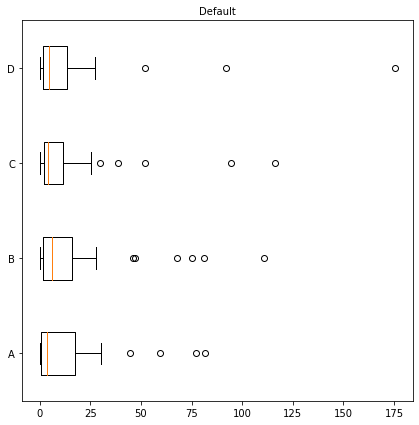

In [13]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7, 7), sharey=True)
axs.bxp(stats, vert=False)
axs.set_title('Default', fontsize=fs)

#axs.set_yscale('log')
#axs.set_xticklabels(['A', 'B', 'C', 'Bla'])

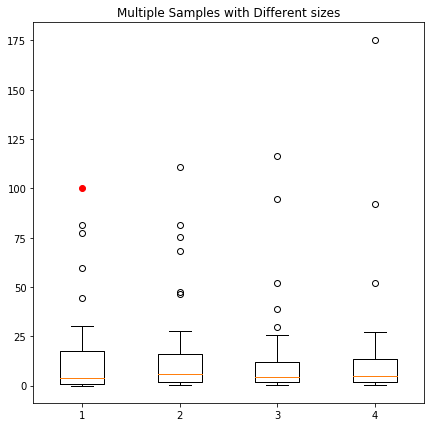

In [14]:
fig7, ax7 = plt.subplots(figsize=(7,7))
ax7.set_title('Multiple Samples with Different sizes')
ax7.boxplot(data)
ax7.scatter(1, 100, color='r')

plt.show()

## Single plot

(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd36d2be810>)

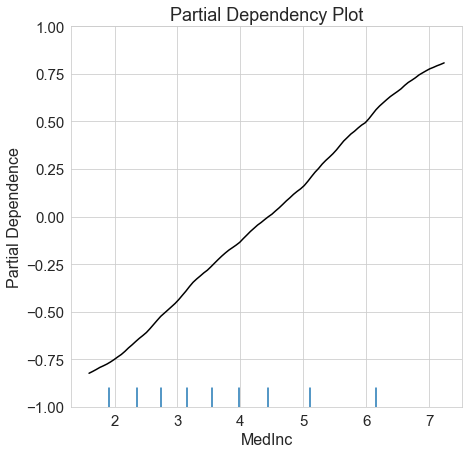

In [15]:
va, li, qtls = make_pdp(X_train, 'MedInc', est, type='regression')
keywords = {'ymin':-1, 'ymax':1}
plot_pdp('MedInc', va, li,type='regression', quantiles=qtls, norm=True, **keywords)

In [16]:
import seaborn as sns

In [22]:
X_train.sample(2)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
1825,2.6750,33.0,4.698413,1.158730,216.0,3.428571,37.93,-122.32
9556,2.1061,16.0,4.638151,1.100295,3589.0,3.529007,37.39,-120.59


In [24]:
def make_ice(df, feature, model, type='classification', quantiles=[0.05, 0.95]):

    """
    Computes partial dependency plot values for a given feature.
    :param df: pandas dataframe
    :param feature: string
    :param model: sci-kit learn model instance
    :param type: string. classification or regression
    :param quantiles: list. min max quantiles to use to exclude extreme values
    """
    
    df_sample = df.sample(50)

    min_val = df[[feature]].quantile(q=quantiles[0]).values[0]
    max_val = df[[feature]].quantile(q=quantiles[1]).values[0]
    values = np.arange(min_val, max_val, (max_val - min_val)* 0.01)
    qtls = {}
    for i in np.arange(0.1,1.0,0.1):
        qtls[np.round(i,1)] = df[[feature]].quantile(q=i).values[0]

    li = []
    va = []

    if type=='classification':
        for i in values:
            _df = df.copy()

            _df[feature].values[:] = i

            output = model.predict_proba(_df)[:, 1]

            vote_1 = len(output[output >= 0.5])
            vote_2 = len(output[output < 0.5])

            output = np.log(vote_1) - 0.5*(np.log(vote_1) + np.log(vote_2))

            avg_output = output.mean()

            li.append(avg_output)
            va.append(i)

    elif type=='regression':
        for i in values:
            _df = df_sample.copy()

            _df[feature].values[:] = i

            output = model.predict(_df)

            #avg_output = output.mean()

            li.append(output)
            va.append(i)

    return va, li, qtls


In [70]:
def plot_ice(feature, va, li, many_li = None, type='classification', quantiles = None, norm=False, axs = None, **kwargs):

    """
    Plot a partial dependency plot
    :param feature: string
    :param va: array
    :param li: array
    :param type: string
    :param quantiles: list of quantile values to plot
    :param norm: boolean. to normalise data so mean value = 0
    :param axs: matplotlib axis if using one from a preexisting plot
    :param **kwargs: other keywords
    """

    sns.set_style("whitegrid")

    if axs == None:
        fig, axs = plt.subplots(1, 1, figsize=(7,7))

    if norm == True:
        li=np.array(li)
        li-=li.mean()
        if many_li is not None:
            many_li = many_li - li.mean()
                

    axs.plot(va,li,c='k', zorder=1, linestyle='-' )

    #axs.set_xlim(kwargs.get("xmin", None), kwargs.get("xmax", None))
    #axs.set_ylim(kwargs.get("ymin", None), kwargs.get("ymax", None))
    axs.set_xlabel(kwargs.get("xlabel",feature), fontsize=kwargs.get("label_fontsize",16))
    axs.set_ylabel(kwargs.get("ylabel","Partial Dependence"), fontsize=kwargs.get("label_fontsize",16))
    axs.set_title(kwargs.get("title","Partial Dependency Plot"), fontsize=kwargs.get("title_fontsize",18))
    axs.tick_params(axis='both', which='major', labelsize=kwargs.get("major_tick_fontsize",15))
    axs.tick_params(axis='both', which='minor', labelsize=kwargs.get("minor_tick_fontsize",15))
    
  
    for i in range(0,len(many_li.columns)):
        print(many_li[i].mean())
        axs.plot(va, many_li[i] - many_li[i].mean(), color='blue', alpha=0.2)

    if quantiles is not None:
        for q in quantiles.keys():
            axs.axvline(quantiles[q], 0, 0.05)


    try:
        return fig, axs
    except:
        return axs


2.354489545743217
2.0500902273942416
3.1390494202737242
3.150764213578068
1.5626654763374415
2.329182720806031
1.455965895044448
1.6555881877957392
2.8443141901212834
2.1033562220937623
2.8544614265312105
1.7748032459838694
2.1950541788869025
2.2968490998687634
2.04299892275891
2.0354024368456702
1.8602148587983889
1.394499003290085
1.9086624224687754
2.875074410548941
2.350272059665656
1.3680572547343788
2.4956770135558948
2.8774196689066565
1.7071785866642923
1.5719941389125074
2.1810847509372295
2.3461717488247142
2.1003313114998763
2.582101426392732
1.6088319635470367
1.128179222013406
2.463257105604694
1.8950604953714383
1.266772069189947
2.113455448940748
1.6480040182690356
1.4273773325904204
3.922850325332949
2.930671646422894
2.7936257654337506
2.6720007841500877
1.8884231749033051
1.8912672843686977
2.242081183382605
1.6463359232239287
1.6753770235773175
1.7684656717606566
1.578667011511795
1.7413449929516027


(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd36c25f090>)

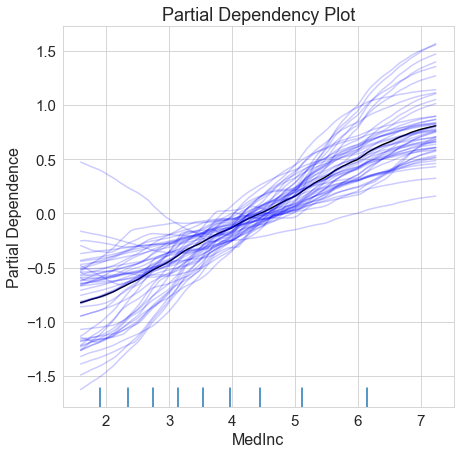

In [72]:
va, li, qtls = make_pdp(X_train, 'MedInc', est, type='regression')
va2, li2, qtls2 = make_ice(X_train, 'MedInc', est, type='regression')

plot_ice('MedInc', va, li, pd.DataFrame(li2), type='regression', quantiles=qtls, norm=True, **keywords)

In [39]:
va, li, qtls = make_ice(X_train, 'MedInc', est, type='regression')

In [42]:
new_df = pd.DataFrame(li)
new_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,1.493694,1.891812,1.688508,0.914484,1.292872,2.979764,0.947521,0.836594,2.001653,0.732719,...,2.089824,0.83973,0.846765,1.310313,2.457360,0.928614,1.223127,2.268109,1.256401,1.504337
1,1.504584,1.913323,1.695077,0.907049,1.296010,2.994736,0.954720,0.842347,2.018161,0.742215,...,2.110375,0.84380,0.854609,1.328277,2.469959,0.949677,1.225284,2.296855,1.277591,1.512885


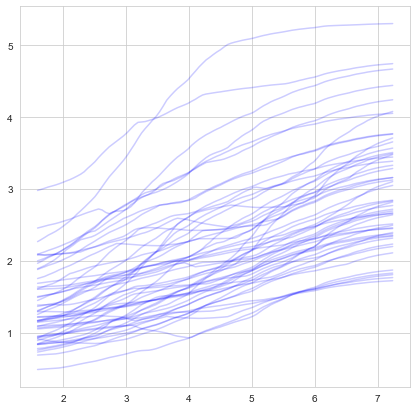

(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd36bda4c10>)

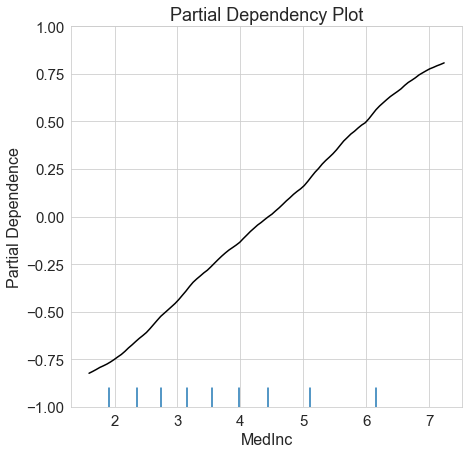

In [21]:
va, li, qtls = make_ice(X_train, 'MedInc', est, type='regression')
plot_ice('MedInc', va, li,type='regression', quantiles=qtls, norm=True, **keywords)

## Multiple plots

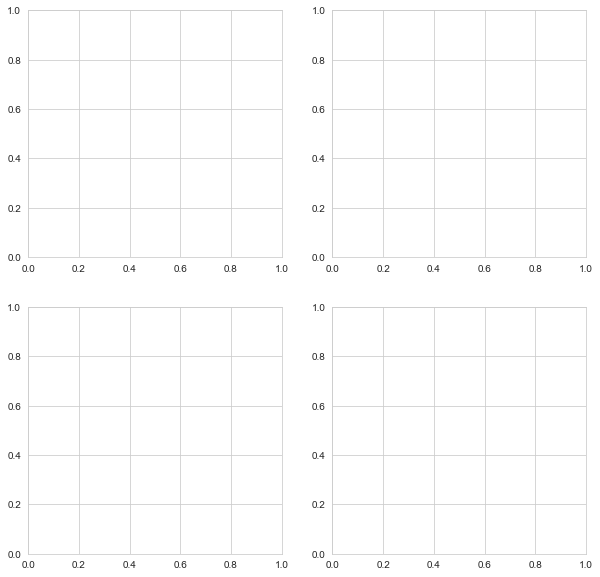

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))

In [6]:
keywords = {'ymin':-1, 'ymax':1, 'title':None}

va, li, qtls = make_pdp(X_train, 'AveOccup', est, type='regression')
plot_pdp('AveOccup', va, li,type='regression', quantiles=qtls, norm=True, ylim=[-1,1], axs=axs[0][0], **keywords)

va, li, qtls = make_pdp(X_train, 'MedInc', est, type='regression')
plot_pdp('MedInc', va, li,type='regression', quantiles=qtls, norm=True, ylim=[-1,1], axs=axs[0][1], **keywords)

va, li, qtls = make_pdp(X_train, 'HouseAge', est, type='regression')
plot_pdp('HouseAge', va, li,type='regression', quantiles=qtls, norm=True, ylim=[-1,1], axs=axs[1][0], **keywords)

va, li, qtls = make_pdp(X_train, 'AveRooms', est, type='regression')
plot_pdp('AveRooms', va, li,type='regression', quantiles=qtls, norm=True, ylim=[-1,1], axs=axs[1][1], **keywords)

In [7]:
fig.suptitle("Partial Dependency plots example", fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=0.92)


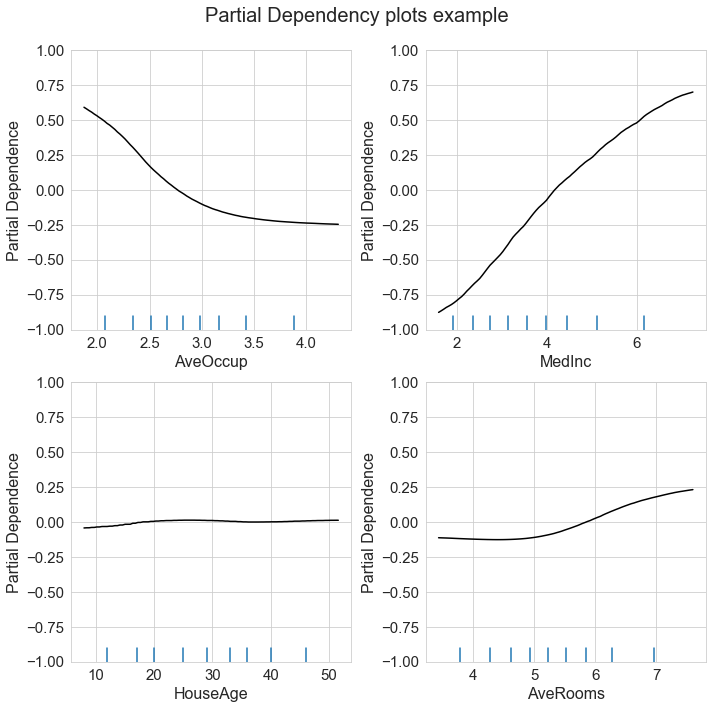

In [8]:
fig

## Edit one of the plots easily 

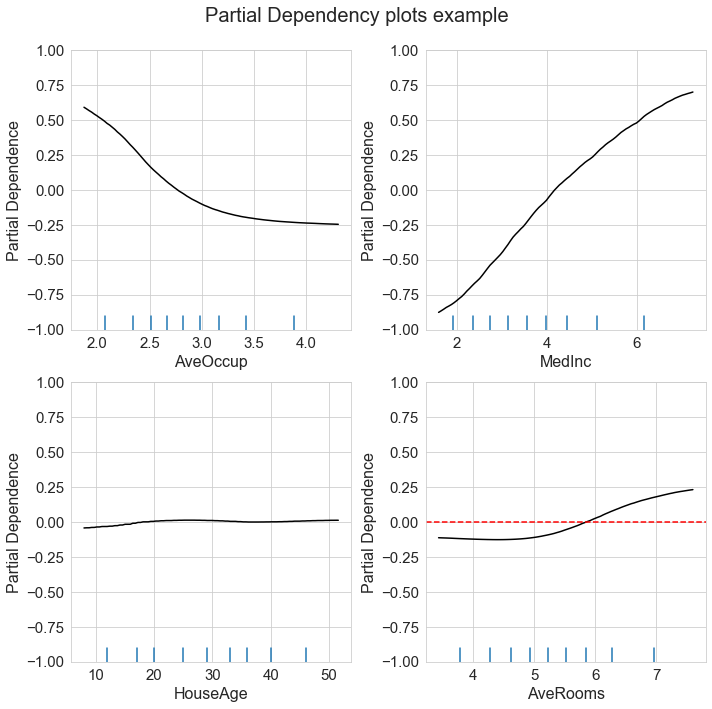

In [9]:
axs[1][1].axhline(0.0, 0, 1.0, linestyle='--', color='red')
fig